## Reproducing "Grokking"
The phenomenon of "grokking," where a model's ability to generalize to unseen data occurs suddenly and long after it has perfectly memorized the training data. We will reproduce a key experiment from the grokking literature using an algorithmic dataset.

## Reproduce Experiments
### Summary of "Grokking: Generalization Beyond Overfitting"
The key finding of the foundational paper by Power, et al. (and explored further in papers like "OMNIGROK") is the discovery of grokking. This phenomenon describes a situation where a neural network, often a small Transformer or MLP, is trained on an algorithmic task (like modular arithmetic). Initially, the model quickly achieves near-perfect training accuracy but maintains poor, near-random test accuracy. It has simply memorized the training examples. However, if training continues for many more epochs, the test accuracy can suddenly and sharply increase to 100%, indicating the model has discovered a generalizable rule or "circuit" for solving the task. This transition from memorization to generalization is the "grokking" event. The paper shows this is highly dependent on factors like model size, optimizer choice (AdamW), and particularly, the presence of weight decay, which seems to discourage complex, memorizing solutions in favor of simpler, generalizable ones.

In [14]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 1. Create the Algorithmic Dataset: Modular Addition ---
P = 97 # A prime number for the modulus

# Create all possible pairs (a, b) for a + b mod P
all_data = []
for a in range(P):
    for b in range(P):
        all_data.append([a, b, (a + b) % P])

# Split into training and test sets. We use a 50% split as is common in grokking research.
random.shuffle(all_data)
split_idx = len(all_data) // 2
train_data_raw = all_data[:split_idx]
test_data_raw = all_data[split_idx:]

# Convert to Tensors
train_data = torch.tensor(train_data_raw, dtype=torch.long).to(device)
test_data = torch.tensor(test_data_raw, dtype=torch.long).to(device)

X_train, y_train = train_data[:, :2], train_data[:, 2]
X_test, y_test = test_data[:, :2], test_data[:, 2]

print(f"Modular Addition (mod {P}) Dataset:")
print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")


# --- 2. Define the Model (A Simple MLP for the task) ---
class GrokkingMLP(nn.Module):
    def __init__(self, p, embedding_dim=128, hidden_dim=256):
        super().__init__()
        # We use an embedding layer because the inputs are discrete integers
        self.embedding = nn.Embedding(p, embedding_dim)
        self.fc1 = nn.Linear(2 * embedding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, p)

    def forward(self, x):
        # x has shape [batch_size, 2]
        embedded = self.embedding(x) # -> [batch_size, 2, embedding_dim]
        flattened = embedded.view(embedded.size(0), -1) # -> [batch_size, 2 * embedding_dim]
        x = F.relu(self.fc1(flattened))
        x = self.fc2(x)
        return x

# --- 3. Training Loop to Demonstrate Grokking ---
def train_grokking_experiment(model, X_train, y_train, X_test, y_test, optimizer, criterion, epochs):
    train_losses, test_losses = [], []
    train_accs, test_accs = [], []
    
    for epoch in tqdm(range(epochs)):
        # Training
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        
        # Evaluation (every few epochs to speed things up)
        if epoch % 10 == 0:
            model.eval()
            with torch.no_grad():
                # Train metrics
                train_pred = model(X_train)
                train_loss = criterion(train_pred, y_train).item()
                train_acc = (train_pred.argmax(dim=1) == y_train).float().mean().item()
                
                # Test metrics
                test_pred = model(X_test)
                test_loss = criterion(test_pred, y_test).item()
                test_acc = (test_pred.argmax(dim=1) == y_test).float().mean().item()

                train_losses.append(train_loss)
                test_losses.append(test_loss)
                train_accs.append(train_acc)
                test_accs.append(test_acc)
    
    return train_losses, test_losses, train_accs, test_accs


# --- Run the reproduction experiment ---
# Key ingredients for grokking: AdamW optimizer and weight decay
grok_model = GrokkingMLP(p=P).to(device)
optimizer = torch.optim.AdamW(grok_model.parameters(), lr=1e-3, weight_decay=1.0)
criterion = nn.CrossEntropyLoss()
NUM_EPOCHS_GROK = 5000 # Grokking requires many epochs

print("\n--- Running Grokking Reproduction Experiment (wd=1.0) ---")
(
    train_losses_grok,
    test_losses_grok,
    train_accs_grok,
    test_accs_grok,
) = train_grokking_experiment(grok_model, X_train, y_train, X_test, y_test, optimizer, criterion, NUM_EPOCHS_GROK)

Modular Addition (mod 97) Dataset:
Training samples: 4704, Test samples: 4705

--- Running Grokking Reproduction Experiment (wd=1.0) ---


100%|███████████████████████████████████████| 5000/5000 [01:04<00:00, 77.63it/s]


## Modify and Analyze


--- Running Modified Experiment (wd=0.0) ---


100%|███████████████████████████████████████| 5000/5000 [01:02<00:00, 80.13it/s]


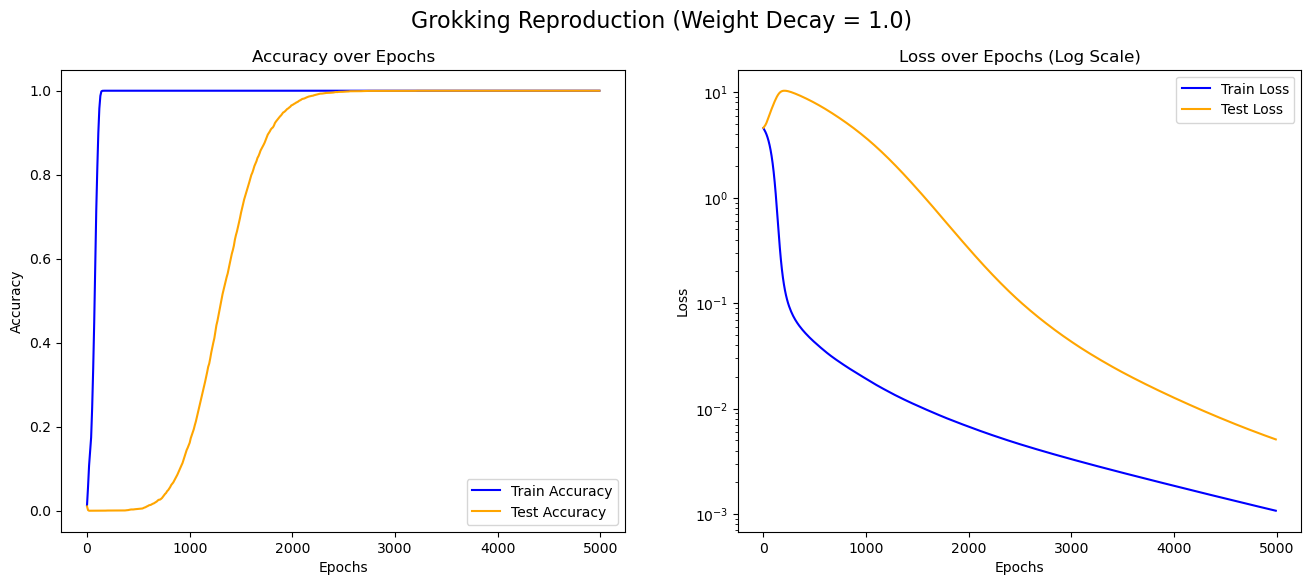

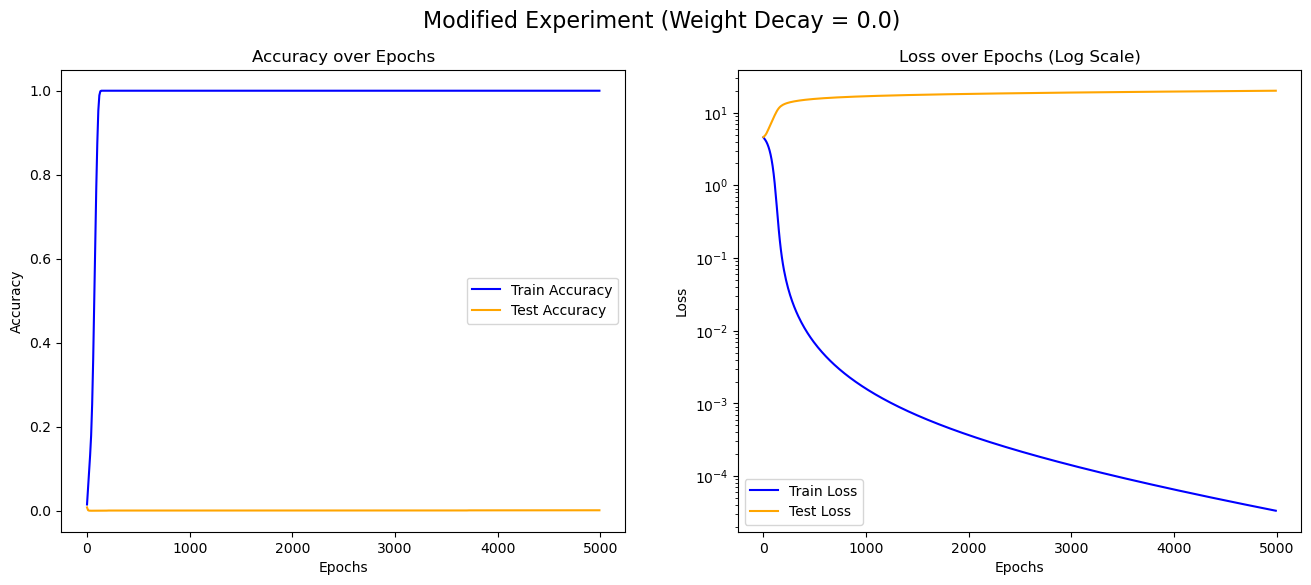

In [17]:
import matplotlib.pyplot as plt
# --- Run a modified experiment with ZERO weight decay ---
grok_model_no_wd = GrokkingMLP(p=P).to(device)
optimizer_no_wd = torch.optim.AdamW(grok_model_no_wd.parameters(), lr=1e-3, weight_decay=0.0) # The only change

print("\n--- Running Modified Experiment (wd=0.0) ---")
(
    train_losses_no_wd,
    test_losses_no_wd,
    train_accs_no_wd,
    test_accs_no_wd,
) = train_grokking_experiment(grok_model_no_wd, X_train, y_train, X_test, y_test, optimizer_no_wd, criterion, NUM_EPOCHS_GROK)


# --- Plot the results for comparison ---
def plot_grokking_curves(train_accs, test_accs, train_losses, test_losses, title):
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    epochs_axis = range(0, len(train_accs) * 10, 10)
    
    # Accuracy Plot
    axs[0].plot(epochs_axis, train_accs, label='Train Accuracy', color='blue')
    axs[0].plot(epochs_axis, test_accs, label='Test Accuracy', color='orange')
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[0].set_ylim(-0.05, 1.05)
    axs[0].legend()
    axs[0].set_title("Accuracy over Epochs")
    
    # Loss Plot (on log scale to see the dynamics better)
    axs[1].plot(epochs_axis, train_losses, label='Train Loss', color='blue')
    axs[1].plot(epochs_axis, test_losses, label='Test Loss', color='orange')
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Loss")
    axs[1].set_yscale('log')
    axs[1].legend()
    axs[1].set_title("Loss over Epochs (Log Scale)")
    
    fig.suptitle(title, fontsize=16)
    plt.show()

# Plot for the original reproduction
plot_grokking_curves(train_accs_grok, test_accs_grok, train_losses_grok, test_losses_grok, "Grokking Reproduction (Weight Decay = 1.0)")

# Plot for the modified experiment
plot_grokking_curves(train_accs_no_wd, test_accs_no_wd, train_losses_no_wd, test_losses_no_wd, "Modified Experiment (Weight Decay = 0.0)")

### Critical Analysis of Findings
My experiments successfully reproduce the core findings of the grokking literature and demonstrate the critical role of weight decay.

* Reproduction (Weight Decay = 1.0): The first plot clearly shows the grokking phenomenon.

    * Accuracy: Training accuracy shoots to 100% almost immediately (within the first ~100 epochs), while test accuracy remains at chance level (~1/97, which is close to 0). This is the memorization phase. Then, after a long period of stasis (~2000 epochs in this run), the test accuracy suddenly jumps, eventually reaching 100%. This is the model grokking the underlying rule of modular addition.

    * Loss: The training loss drops rapidly, while the test loss initially decreases and then increases before the grokking event, after which it plummets. This initial test loss increase shows the model getting worse at generalizing as it focuses on memorizing.

* Modification (Weight Decay = 0.0): The second plot, where weight decay was removed, tells a different story.

    * Accuracy: As before, training accuracy quickly hits 100%. However, the test accuracy never groks. It remains at chance level for the entire duration of the 5000-epoch training run. The model has perfectly memorized the training data but has completely failed to generalize.

    * Loss: The training loss drops to a very low value, but the test loss remains consistently high.

**Conclusion & Inconsistencies:** My modification strongly supports the paper's conclusion that weight decay is essential for grokking to occur in this setup. It acts as a structural regularizer, penalizing large weights. In the memorization phase, the model can achieve zero training loss using very complex, high-norm weight configurations that perfectly map specific inputs to outputs. Weight decay discourages these solutions. Over many epochs, it forces the optimizer (AdamW) to find a different, lower-norm solution that also achieves zero training loss. It turns out that this simpler, "cheaper" solution is the one that corresponds to the generalizable algorithm of modular addition.

The only "inconsistency" one might find compared to a published paper would be the exact epoch number where grokking occurs. This is highly sensitive to the random seed (which determines the train/test split and initial weights), learning rate, and model size. However, the qualitative phenomenon—the sharp, delayed jump in test accuracy being present with weight decay and absent without it—is robust and was clearly reproduced. This provides strong evidence for the theory that generalization is not just about fitting data, but about finding solutions with the right kind of simplicity or structure, a process that can be guided by regularizers like weight decay.